In [36]:
import ncmcm as nc
from IPython.display import display
import os
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import pickle
os.chdir('demos')

### Mouse Data
This is data from the mouse brain. You first need to download you data from [here](https://dandiarchive.org/dandiset/000579/0.230728.1727/files?location=sub-10&page=1). I used the first file which is data from mouse 10 from the 21. September 2017. The data comes from this [publication](https://www.cell.com/neuron/pdf/S0896-6273(22)00453-6.pdf).

The following is all preprocessing to get the data from the NWB-format.


In [2]:
filepath = "ncmcm/data/datasets/mouse_10/sub-10_ses-mouse-10-session-date-2017-09-21-area-V1-L23-multi-plane-imaging_behavior+ophys.nwb"
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwbfile = io.read()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.6.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.3.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


### Imaging Data
The most important part here is the pixel_mask which contains the neuronal data we need for NC-MCM.

In [3]:
# get data from the first PlaneSegmentation as a dataframe
planeSeg_0_df = nwbfile.processing['ophys']['ImageSegmentation']['PlaneSegmentation_0'].to_dataframe()
planeSeg_0_df.head(5)

,ml,ap,depth,area,mTagBFP2,mScarlet,pixel_mask
id,,,,,,,
0,-2.71753,-3.21788,0.11,V1,False,False,"[[229, 76, 91947.16], [230, 76, 130799.37], [2..."
1,-2.76642,-3.16481,0.11,V1,False,False,"[[264, 113, 45804.51], [265, 113, 64200.27], [..."
2,-3.02527,-3.00245,0.11,V1,False,False,"[[443, 226, 84415.805], [444, 226, 89784.02], ..."
3,-2.91319,-3.04176,0.11,V1,True,False,"[[367, 200, 7744.4453], [362, 201, 7726.138], ..."
4,-2.56678,-2.80399,0.11,V1,False,False,"[[138, 389, 93532.75], [139, 389, 125248.22], ..."


However, we can also directly access the deconvolved neuronal activity of plane 0 in this dataset.

In [4]:
deconv_0 = nwbfile.processing['ophys']['deconvolved_activity_plane_0'].data[:]

### Supplement Information

In [5]:
# We can see all the supplemental information that is captured for everyone of the 410 trials
trial_df = nwbfile.trials.to_dataframe()
print(trial_df.shape)
trial_df.iloc[0:5]

(410, 16)


,start_time,stop_time,is_vis,is_ruleA,is_switch,is_cueB,is_choL,is_correct,association_mat,rule_belief,signed_bias,rule_following,bias_following,prob_actual_cho,trial_onset_plane_frame_idx,trial_offset_plane_frame_idx
id,,,,,,,,,,,,,,,,
0,27.40725,38.93475,False,True,False,False,False,True,"[0.1915447860956192, 0.808455228805542, 0.1745...",0.017014,0.633925,0.008507,-0.316962,0.191545,"[95, 95, 95, 95, 94]","[132, 132, 132, 132, 132]"
1,38.95450,53.71500,True,True,False,False,False,True,"[0.4683721661567688, 0.5316278338432312, 0.381...",0.087143,0.150398,0.043571,-0.075199,0.468372,"[165, 164, 164, 164, 164]","[221, 221, 221, 220, 220]"
2,53.73325,67.30600,False,True,False,False,False,True,"[0.5884299874305725, 0.4115700125694275, 0.568...",0.020030,-0.156830,0.010015,0.078415,0.588430,"[253, 253, 253, 253, 252]","[302, 302, 302, 302, 302]"
3,67.32600,79.86375,False,True,False,False,False,True,"[0.6695836782455444, 0.3304162919521332, 0.633...",0.036280,-0.302887,0.018140,0.151444,0.669584,"[335, 334, 334, 334, 334]","[378, 378, 377, 377, 377]"
4,79.88150,93.72075,False,True,False,False,False,True,"[0.740466296672821, 0.25953370332717896, 0.670...",0.069668,-0.411264,0.034834,0.205632,0.740466,"[410, 410, 410, 409, 409]","[461, 461, 460, 460, 460]"


### This is an explanation for each of the headers

#### The trial table contains basic information about trials:

* start_time: start time of this trial from session onset in second
* stop_time: stop time of this trial from session onset in second
* is_vis: whether the trial was a visually guided trial
* is_ruleA: whether the trial happened during rule A; rule A: BL & WR, rule B: WL & BR
* is_switch: whether a rule switch happened on the trial
* is_cueB: whether the trial had a black cue; True: black, False: white
* is_choL: whether the mouse made a left choice on the trial; True: left, False: right
* is_correct: whether the trial was correct

#### ... about rules:

* association_mat: behavioral LSTM predicted conditional probability; order: P(R|W), P(L|W), P(R|B), P(L|B)
* rule_belief: the rule belief on the trial; directionality: positive: rule B, negative: rule A
* signed_bias: the singed choice bias on the trial; directionality: positive: left bias, negative: right bias
* rule_following: the rule-following on the trial; values between -0.5 ~ 0.5
* bias_following: the bias-following on the trial; between -0.5 ~ 0.5
* prob_actual_cho: the probability of actual choice on the trial, i.e. P(actual choice|actual cue)

#### ... and other information:

* trial_onset_plane_frame_idx: for each imaging plane, the frame index for this trial's onset
* trial_offset_plane_frame_idx: for each imaging plane, the frame index for this trial's offset

### Decode Movements from position
To get meaningful results for our application of NCMCM, we need behaviors that can be deduced from the neuronal data. I tried to decode the movement direction and turning behavior from the position of the mouse at each frame.

In [6]:
imaging_timestamps_0 = nwbfile.processing['ophys']['deconvolved_activity_plane_0'].timestamps
time_diffs_0 = np.diff(imaging_timestamps_0)
mean_time_step_0 = np.mean(time_diffs_0)
pos = nwbfile.processing['behavior']['frame_aligned_position']['frame_aligned_forward_and_lateral_position']

states = ['standing still', 'moving forward', 'moving backward', 'going right', 'going left', 'invisible']

In [7]:
# We set a threshold of what is defined as moving. 
forward_threshold = 0.0001  
lateral_threshold = 0.00001   
movements = np.zeros(imaging_timestamps_0.shape)

# Loop through imaging timestamps and categorize behaviors
for i, timestamp in enumerate(imaging_timestamps_0):
    # For every 5th frame of imaging-timestamps we have the neuronal data
    index = i * 5
    
    # Get the forward and lateral positions at the current and previous index
    forward_pos, lateral_pos = pos.data[index]
    prev_forward_pos, prev_lateral_pos = pos.data[index - 1]
    
    # Calculate changes in forward and lateral positions
    forward_change = forward_pos - prev_forward_pos
    lateral_change = lateral_pos - prev_lateral_pos
        
    # Categorize behaviors based on changes
    # if np.abs(forward_change) < forward_threshold and np.abs(lateral_change) < lateral_threshold: # standing still
    #     movements[i] = 0
    # elif forward_change > forward_threshold: # moving forward
    #     movements[i] = 1
    # elif forward_change < -forward_threshold:
    #     movements[i] = 2
    # elif lateral_change > lateral_threshold:
    #     movements[i] = 3
    # elif lateral_change < -lateral_threshold:
    #     movements[i] = 4
    # else:
    #     movements[i] = 5
        
    # Categorize behaviors based on changes
    if np.abs(forward_change) < forward_threshold and np.abs(lateral_change) < lateral_threshold: # standing still
        movements[i] = 0
    elif forward_change > forward_threshold and np.abs(lateral_change) < lateral_threshold: # moving forward
        movements[i] = 1
    elif forward_change > forward_threshold and lateral_change > lateral_threshold: # moving forward-right
        movements[i] = 6
    elif forward_change > forward_threshold and lateral_change < -lateral_threshold: # moving forward-left
        movements[i] = 7
    elif forward_change < -forward_threshold and np.abs(lateral_change) < lateral_threshold: # moving backward
        movements[i] = 2
    elif forward_change < -forward_threshold and lateral_change > lateral_threshold: # moving backward-right
        movements[i] = 8
    elif forward_change < -forward_threshold and lateral_change < -lateral_threshold: # moving backward-left
        movements[i] = 9
    elif lateral_change > lateral_threshold and np.abs(forward_change) < forward_threshold: # going right
        movements[i] = 3
    elif lateral_change < -lateral_threshold and np.abs(forward_change) < forward_threshold: # going left
        movements[i] = 4
    else: # invisible or undefined movement
        movements[i] = 5

# Update the list of states
states = ['standing still', 'moving forward', 'moving backward', 'going right', 'going left', 'invisible', 'moving forward-right', 'moving forward-left', 'moving backward-right', 'moving backward-left']


# Now, the 'behaviors' array contains the categorized behaviors for each frame in imaging timestamps.
print(movements.shape)
#states = ['standing still', 'moving forward', 'moving backward', 'going right', 'going left', 'invisible']
print(np.unique(movements, return_counts=True))

(37748,)
(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([  330, 16431,  1408,    34,    21, 13748,  1857,  3758,    54,
         107]))


### Application of NCMCM
Now we can finally apply the NCMCM framework. Lets start by plotting the timeseries for neuronal activity and behaviors.

B has to be transformed into a integer-array. Translation is accessed by'self.states'.


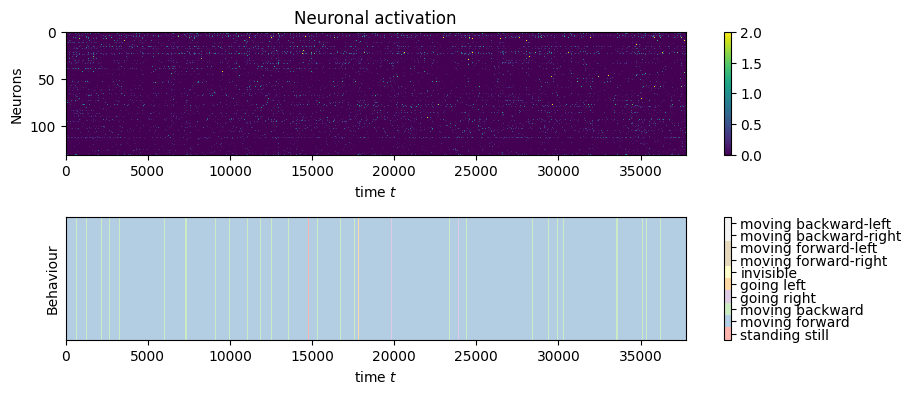

In [9]:
mouse_plane0_complete = nc.Database(neuron_traces=deconv_0.T, 
                                 behavior=movements,
                                 behavioral_states=states,
                                 fps=mean_time_step_0)
mouse_plane0_complete.plotting_neuronal_behavioral()


In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
mouse_plane0_complete.fit_model(logreg, ensemble=True)
mouse_plane0_complete.cluster_BPT_single(nclusters=3, nrep=3)

Accuracy for full training data: 0.8264278902193494
Creating new
Testing markovianity for 3 clusters - repetition 1
Testing markovianity for 3 clusters - repetition 2
Testing markovianity for 3 clusters - repetition 3


True

After clustering the behavioral probabilities, we can display a step_plot which shows us the step by step application of NCMCM.

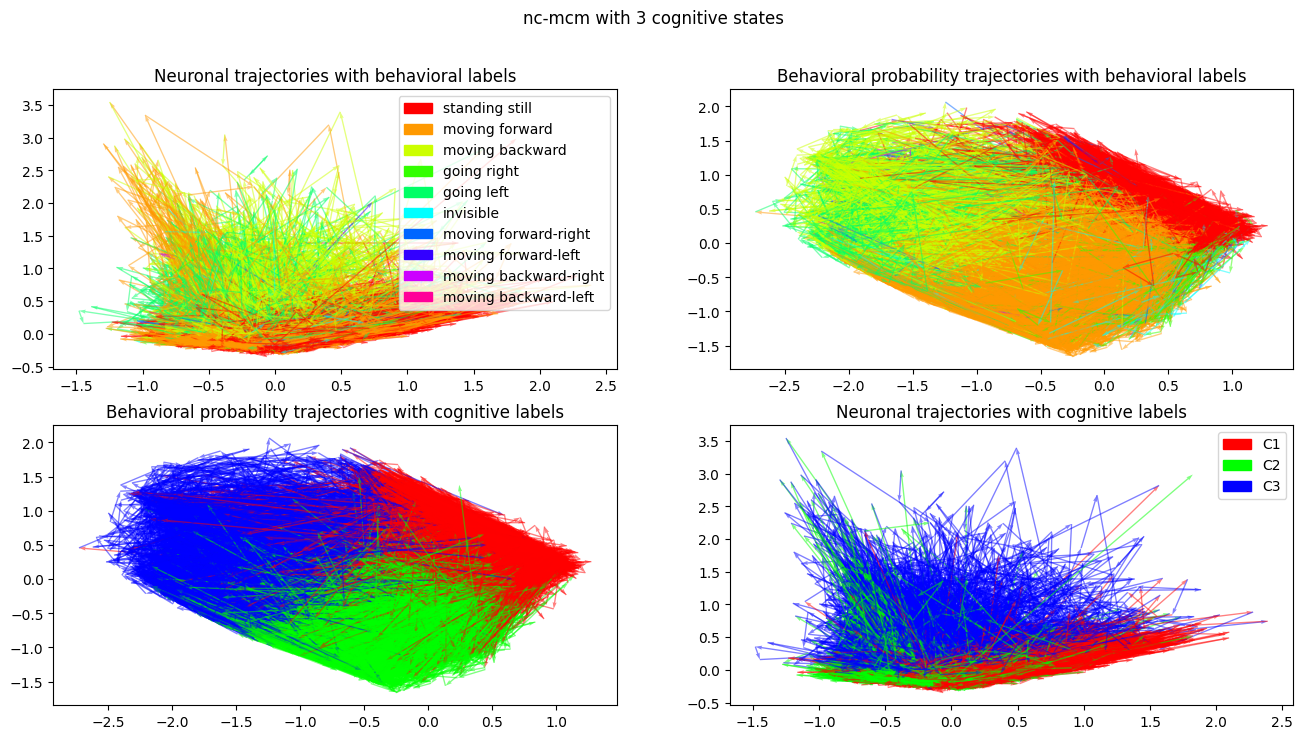

True

In [12]:
mouse_plane0_complete.step_plot(clusters=3)

Clustering was chosen according to best p-memorylessness.


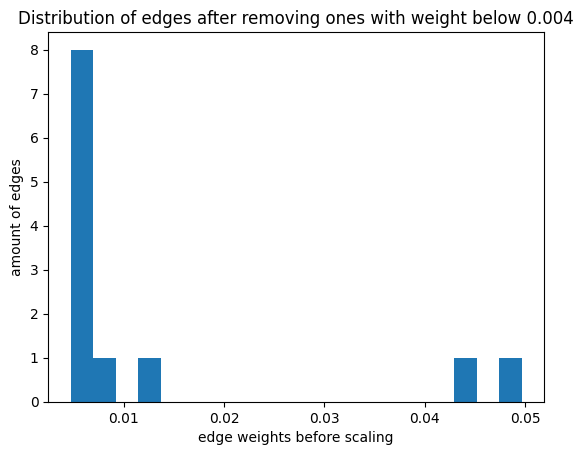

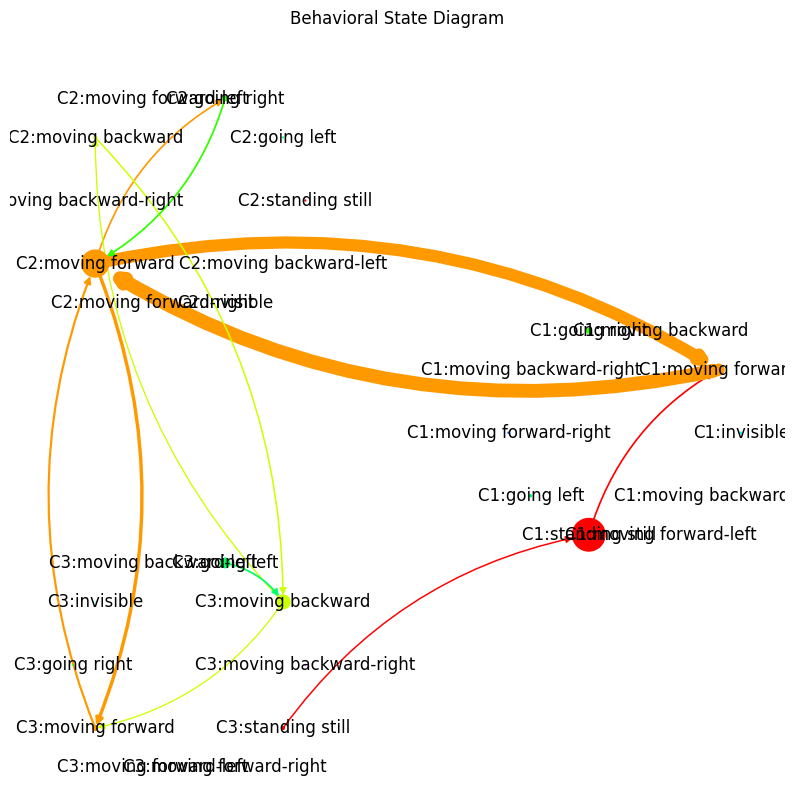

True

In [32]:
mouse_plane0_complete.behavioral_state_diagram(cog_stat_num=3, weights_hist=True, interactive=False, threshold=0.004, bins=20, figsize=(10,10))

Clustering was chosen according to best p-memorylessness.


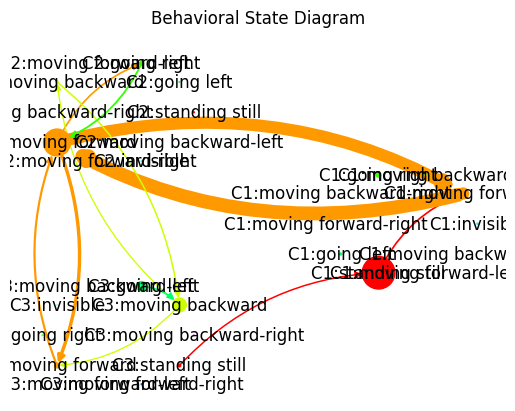

Interactive_mouse_C3.html
Plot has been saved under: Interactive_mouse_C3.html


True

In [33]:
mouse_plane0_complete.behavioral_state_diagram(cog_stat_num=3, interactive=True, threshold=0.004)

### Visualizer
After the NCMCM network did not help us a lot with untangling the neuronal activity maybe a BunDLeNet can help us get some information from it.

In [15]:
mouse_plane0_vs = nc.create_visualizer(mouse_plane0_complete, epochs=2500)

Losses 0.004810 0.000482 0.005292: 100%|██████████| 2500/2500 [39:00<00:00,  1.07it/s]


Points have coordinate shape:  (37733, 3)
Accuracy of BundDLeNet: 0.98


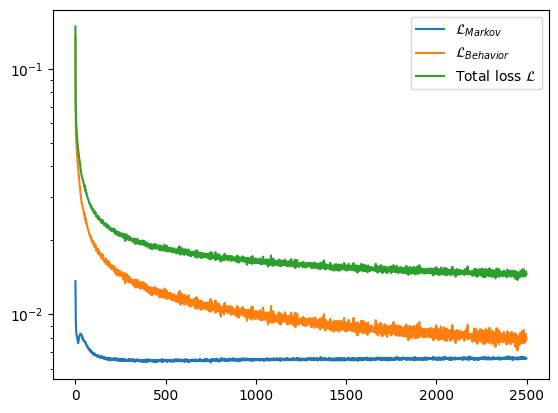

In [34]:
mouse_plane0_vs.plot_loss()

In [35]:
%matplotlib notebook
mouse_plane0_vs.make_comparison(show_legend=True, quivers=True)

<IPython.core.display.Javascript object>

True

### Insights
From the output we can see that BunDLeNet is successful in predicting the behaviors of the mouse most of the time (in-sample accuracy of 99.3%). We can also see that the model had problems distinguishing the left and right turning behaviors. All of the "goingleft" behaviors were predicted incorrectly. With most of them being predicted as "goingright". 

Furthermore, we see that in the cases the mouses position was not detected but the imaging data was present, the mouse is expected to mainly turn right ("goingright").

The behavior "standingstill" is also very easy to predict for the model with just 2 incorrect predictions out of 13733. Indicating clear difference between moving and not moving in the mouse' neuronal activity. The "movingforward" and "movingbackward" behavior also showed pretty good results.

In [37]:
with open(f'data/data_mouse_vis.pkl', 'wb') as file:
		pickle.dump(mouse_plane0_vs, file)		
        
with open(f'data/data_mouse_db.pkl', 'wb') as file:
        pickle.dump(mouse_plane0_complete, file)